# Google Colab 한글 폰트 설치

In [ ]:
import sys

# Google Colab 환경에서 실행 중인지 확인
if 'google.colab' in sys.modules:
    # debconf를 Noninteractive 모드로 설정
    !echo 'debconf debconf/frontend select Noninteractive' | \
    debconf-set-selections

    # fonts-nanum 패키지를 설치
    !sudo apt-get -qq -y install fonts-nanum

    # Matplotlib의 폰트 매니저 가져오기
    import matplotlib.font_manager as fm

    # 나눔 폰트의 시스템 경로 찾기
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])

    # 찾은 각 나눔 폰트를 Matplotlib 폰트 매니저에 추가
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

Selecting previously unselected package fonts-nanum.
(Reading database ... 123623 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'NanumGothic'    #사용 방법1
plt.rc('font', family='NanumBarunGothic', size=11) #사용 방법2
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False
print(plt.rcParams['font.family'], plt.rcParams['font.size'])   # 폰트확인

['NanumBarunGothic'] 11.0


- 테스트

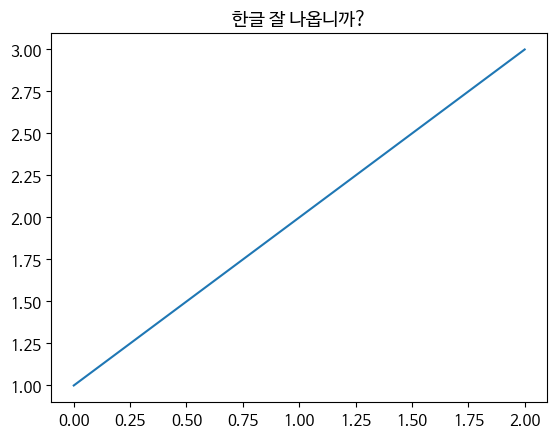

In [ ]:
plt.plot([1, 2, 3])
plt.title("한글 잘 나옵니까?")
plt.show()

# Google Colab과 드라이브 연동

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# 주요 라이브러리 및 환경설정

In [ ]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [ ]:
print(tf.__version__)

2.17.0


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

# 데이터 불러오기
- UCI 기계학습 Repo에서 사용할 수 있는 원본 데이터 집합의 단축 및 정리된 버전
- 2016년 9월 29일 오후 5시에 시작, 2019년 9울 30일 오후 11시에 끝.

In [ ]:
import pandas as pd
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/2024/알파코/time_series/data/"

train_df = pd.read_csv(DATA_PATH + 'train.csv', index_col=0)
val_df = pd.read_csv(DATA_PATH + 'val.csv', index_col=0)
test_df = pd.read_csv(DATA_PATH + 'test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


# DataWindow 클래스
- 입력의 너비, 레이블의 너비, 이동(shift)을 기반으로 한다.
- 입력의 너비는 단순히 예측을 위해 모델에 입력되는 시간 단계의 개수
  + 24시간의 데이터 입력, 입력의 너비는 24
  + 12시간의 데이터 입력, 입력의 너비는 12
- 레이블의 너비 : 예측의 시간 단계 수와 동일
  + 하나의 시간 단계만 예측 : 레이블 너비 1
  + 하루 동안의 데이터를 예측하는 경우 레이블 너비 24
- 이동은 입력과 예측을 구분하는 시간 단계의 수
  + 다음 시간 단계를 예측하는 경우 이동의 너비는 1
  + 다음 24시간을 예측하는 경우 이동의 너비는 24

## split_to_inputs_labels 함수
- 데이터 윈도우 입력, 레이블, 두 개의 윈도우로 분리
- 큰 데이터 윈도우를 입력과 레이블, 두 개의 윈도우로 간단히 분리

In [ ]:
class DataWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch

        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )

        ds = ds.map(self.split_to_inputs_labels)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

# 딥러닝 LSTM 모델 적용

In [ ]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')

    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])

    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])

    return history

In [ ]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}
column_indices

{'temp': 0, 'clouds_all': 1, 'traffic_volume': 2, 'day_sin': 3, 'day_cos': 4}

## 단일 단계 LSTM 모델
- 24시간의 데이터 입력으로 사용 후 다음 시간 단계 예측
- 모델을 훈련할 데이터 윈도우 만들기
- 24시간의 데이터를 입력으로 사용하는 넓은 윈도우
- 도식화 위해 label_width도 24로 설정
- 예측값을 24개의 시간 단계에 걸쳐 실제값과 비교

In [ ]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['traffic_volume'])
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['traffic_volume'])

- 도식화를 위해 더 넓은 윈도우를 정의, 모델의 많은 예측 시각화
- 그렇지 않으면 하나의 입력 데이터 요소와 하나의 출력 예측만 시각화

### LSTM 모델 정의
- Sequential 모델 사용해 네트워크에 서로 다른 계층 쌓기

In [ ]:
# 기존 윈도잉 모델에서 가져옴 (비교 위해)
mae_val = [0.083, 0.068, 0.033]
mae_test = [0.081, 0.068, 0.029]

- 숨겨진 상태와 셀 상태의 형태로 배열의 과거 정보를 사용하도록 케라스에 신호 보내기
  + return_sequences = True로 설정
  + 교통량만 예측하기 때문에 units가 1인 단순한 Dense 계층으로 출력 계층 정의

In [ ]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units=1)
])

history = compile_and_fit(lstm_model, wide_window)

val_performance = {}
performance = {}

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0492 - mean_absolute_error: 0.1607 - val_loss: 0.0113 - val_mean_absolute_error: 0.0782
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.0090 - mean_absolute_error: 0.0696 - val_loss: 0.0052 - val_mean_absolute_error: 0.0524
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0050 - mean_absolute_error: 0.0514 - val_loss: 0.0040 - val_mean_absolute_error: 0.0459
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0043 - mean_absolute_error: 0.0471 - val_loss: 0.0037 - val_mean_absolute_error: 0.0441
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0040 - mean_absolute_error: 0.0452 - val_loss: 0.0034 - val_mean_absolute_error: 0.0425
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0037 - mean_absolute_error: 0.0430 - val_loss: 0.0031 - val_mean_absolute_error: 0.0398
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0034 - mean_absolute_error: 

### 모델 예측 시각화 확인
- 세 개의 샘플링된 배열에 대한 모델의 예측 시각화
- 많은 예측이 레이블과 겹치는 것 확인, 정확한 예측을 하는 성능이 우수한 모

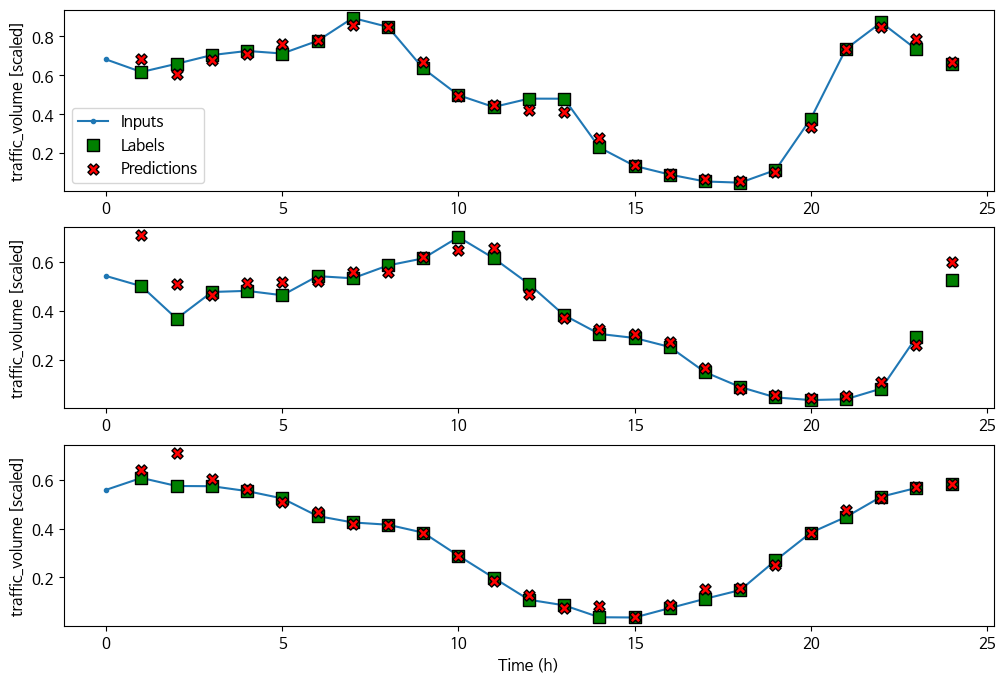

In [ ]:
wide_window.plot(lstm_model)

### 평가지표 비교

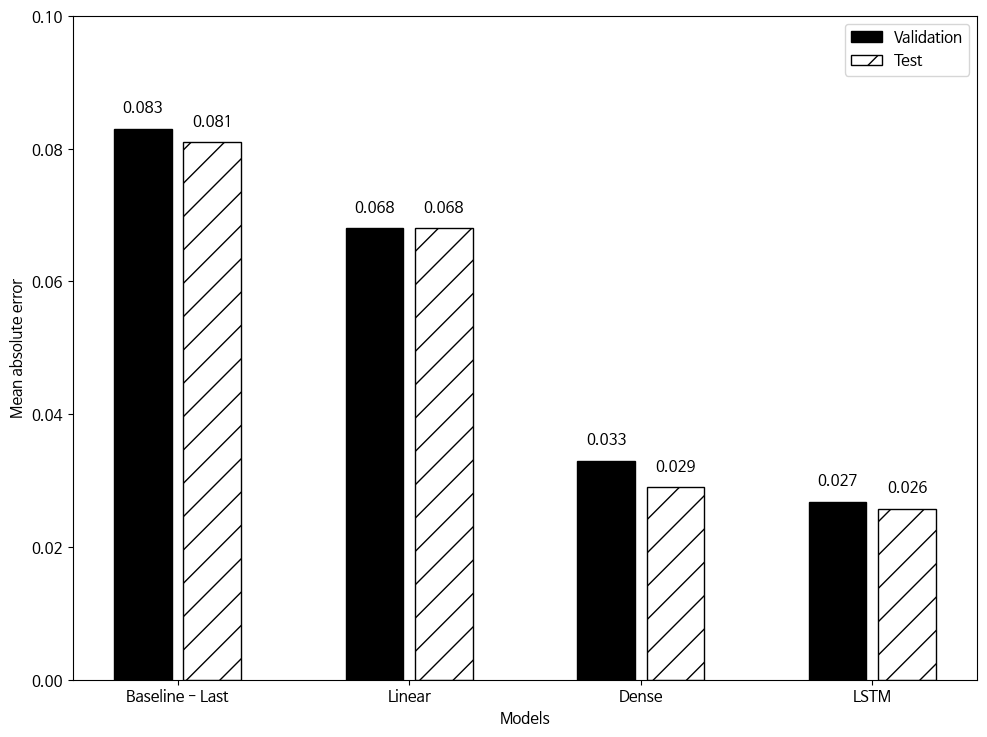

In [ ]:
mae_val.append(val_performance['LSTM'][1])
mae_test.append(performance['LSTM'][1])

x = np.arange(4)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

plt.show()

## 다중 단계 LSTM 모델
- 24시간의 입력 윈도우를 사용하여 향후 24시간 동안의 교통량 예측
- 모델에 입력할 시간 윈도우 정의

In [ ]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

### LSTM 모델 정의

In [ ]:
# 기존 윈도잉 모델에서 가져옴 (비교 위해)
ms_mae_val = [0.352, 0.347, 0.088, 0.078]
ms_mae_test = [0.347, 0.341, 0.076, 0.064]

In [ ]:
ms_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_lstm_model, multi_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.val)
ms_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.0893 - mean_absolute_error: 0.2220 - val_loss: 0.0215 - val_mean_absolute_error: 0.1044
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0181 - mean_absolute_error: 0.0952 - val_loss: 0.0173 - val_mean_absolute_error: 0.0883
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0153 - mean_absolute_error: 0.0842 - val_loss: 0.0168 - val_mean_absolute_error: 0.0897
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.0145 - mean_absolute_error: 0.0811 - val_loss: 0.0157 - val_mean_absolute_error: 0.0830
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0140 - mean_absolute_error: 0.0789 - val_loss: 0.0156 - val_mean_absolute_error: 0.0791
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.0136 - mean_absolute_error: 0.0772 - val_loss: 0.0155 - val_mean_absolute_error: 0.0854
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0133 - mean_absolute_error: 

### 모델 예측 시각화 확인
- 일부 예측이 일치하는 것도 존재함

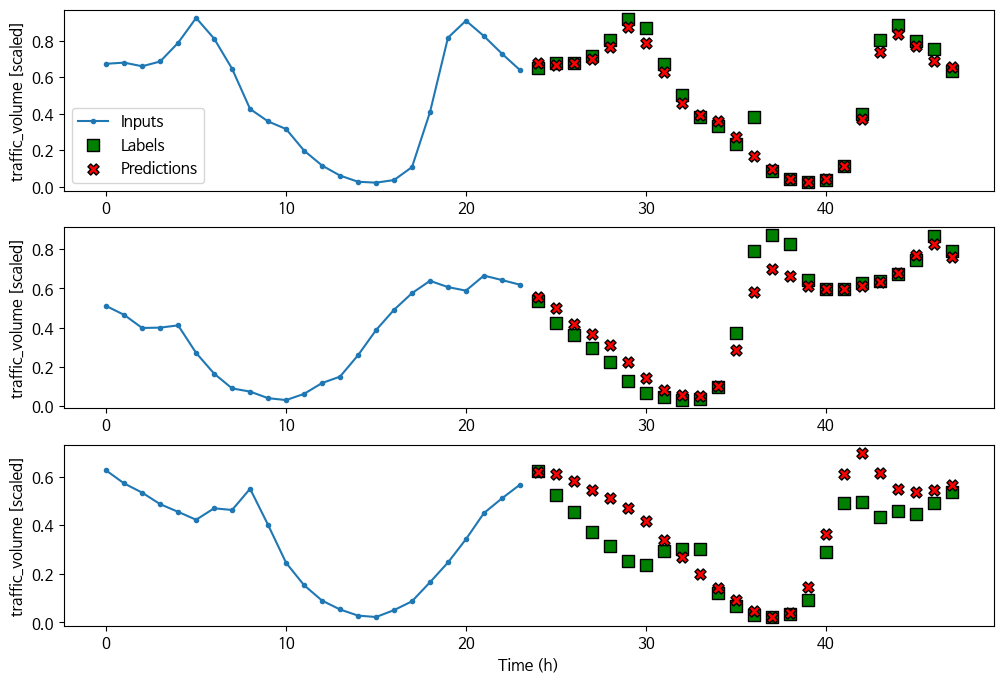

In [ ]:
multi_window.plot(ms_lstm_model)

### 평가지표 비교
- 가장 낮은 MAE를 달성한 LSTM 모델 확인

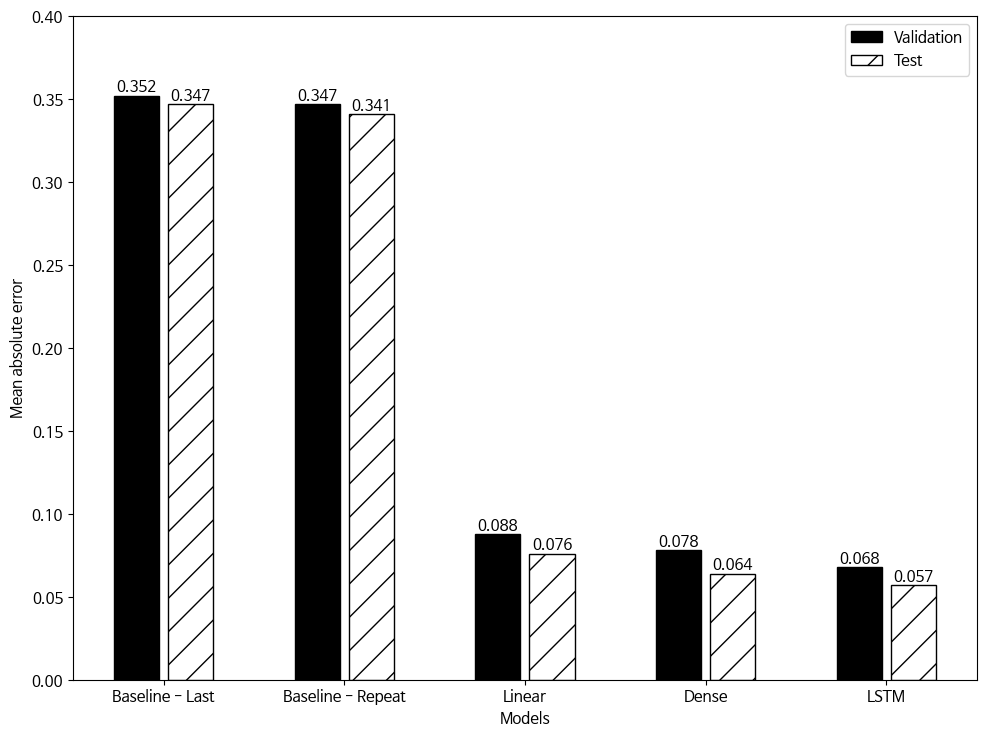

In [ ]:
ms_mae_val.append(ms_val_performance['LSTM'][1])
ms_mae_test.append(ms_performance['LSTM'][1])

x = np.arange(5)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

plt.show()

## 다중 출력 모델 LSTM 모델
- 24시간의 입력 데이터 사용하여 네트워크가 일련의 데이터 요소 처리
- 과거 정보를 사용하여 예측 생성
- 예측은 다음 시간 단계의 교통량과 온도 모두에 대한 것

In [ ]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['temp','traffic_volume'])
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp','traffic_volume'])

### LSTM 모델 정의

In [ ]:
# 기존 강의안 자료 확인
mo_mae_val = [0.048, 0.039, 0.023]
mo_mae_test = [0.047, 0.036, 0.020]

### 모델 예측 시각화 확인

In [ ]:
mo_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units = 2)
])

history = compile_and_fit(mo_lstm_model, mo_wide_window)

mo_val_performance = {}
mo_performance = {}

mo_val_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.val)
mo_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - loss: 0.0954 - mean_absolute_error: 0.2120 - val_loss: 0.0122 - val_mean_absolute_error: 0.0723
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0091 - mean_absolute_error: 0.0629 - val_loss: 0.0052 - val_mean_absolute_error: 0.0474
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0046 - mean_absolute_error: 0.0442 - val_loss: 0.0032 - val_mean_absolute_error: 0.0372
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0033 - mean_absolute_error: 0.0372 - val_loss: 0.0026 - val_mean_absolute_error: 0.0338
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0028 - mean_absolute_error: 0.0342 - val_loss: 0.0023 - val_mean_absolute_error: 0.0310
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0026 - mean_absolute_error: 0.0322 - val_loss: 0.0021 - val_mean_absolute_error: 0.0298
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0024 - mean_absolute_error: 0

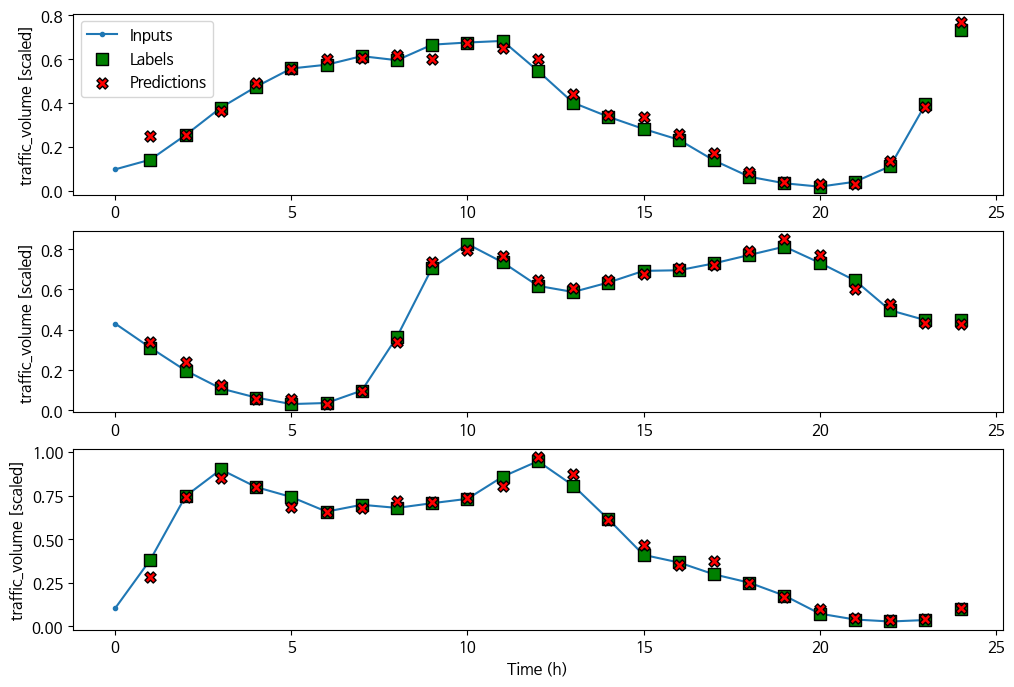

In [ ]:
mo_wide_window.plot(mo_lstm_model)

### 평가지표 비교

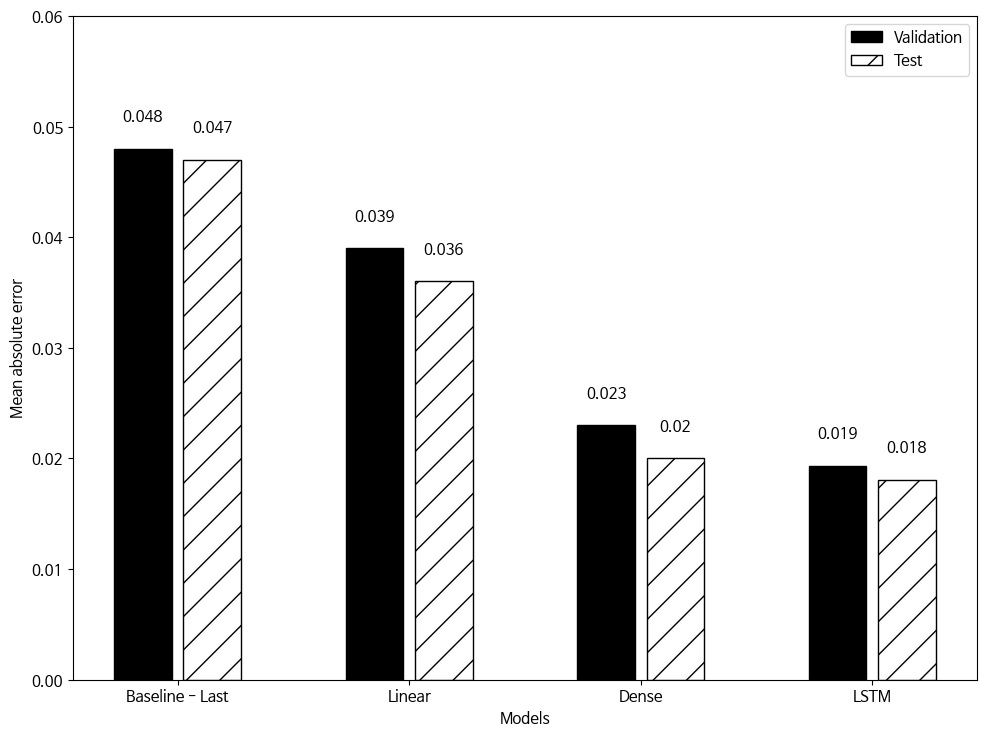

In [ ]:
mo_mae_val.append(mo_val_performance['LSTM'][1])
mo_mae_test.append(mo_performance['LSTM'][1])

x = np.arange(4)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

plt.show()